# Introduction

In this notebook, we introduce *Tiny Robot*, which is a simple example of Markov Decision Process (MDP). Although the example is simple, it actually represents a general discrete time MDP with a finite number of states.

We will first present code to represent the MDP in "pure Python". This way, we can explore the key concepts in MDPs without the complexity of a full-fledged library. Later, we will see how to code and solve the Tiny Robot problem using TF-Agents, the powerful TensorFlow library for RL.

Run the cell below to import the modules and functions used in the notebook:

In [1]:
# Numpy: efficient multidimensional arrays
import numpy as np

# matplotlib: interactive plots
import matplotlib.pyplot as plt

# Tiny Robot

Tiny Robot lives in an environment consisting of four rooms arranged in a $4\times4$ grid. We number the rooms $0$, $1$, $2$ and $3$, clockwise starting with the upper-left room.

In each time step, the robot can stay in the same room or move to an adjacent room. The robot can influence to which room it is going to move in the next step by choosing an action. There are two possible actions, numbered $0$ and $1$.

We will concentrate in an example in which there are two actions, numbered $0$ and $1$:

- If action $0$ is selected, the robot stays in the same room with probability $2/3$, or moves to the next room in the clockwise direction with probability $1/3$.

- If action $1$ is selected, the robot moves to one of the adjacent rooms, each with probability $1/2$

These specifications can be represented by a transition probability matrix, given by the following tables:

<center>

| Action 0 |          |          |          |          ||| Action 1 |          |          |          |          |
:---------:|:--------:|:--------:|:--------:|:--------:|||:--------:|:--------:|:--------:|:--------:|:--------:|
|          |0         |1         |2         |3         |||          |0         |1         |2         |3         |
|0         |2/3       |1/3       |0         |0         |||0         |0         |1/2       |0         |1/2       |
|1         |0         |2/3       |1/3       |0         |||1         |1/2       |0         |1/2       |0         |
|2         |0         |0         |2/3       |1/3       |||2         |0         |1/2       |0         |1/2       |
|3         |1/3       |0         |0         |2/3       |||3         |1/2       |0         |1/2       |0         |

</center>

In the tables above, rows represent the current room the robot is in, and the columns represent the room the robot moves to in the next step.

When visiting a room, the robot performs a task and receives a reward for it. The rewards are specified in the next table. The reward depends on both the room and the chosen action, according to the following table:

<center>

| Rewards  |          |          |          |           |
|:---------|:--------:|:--------:|:--------:|:---------:|
| Room     |0         |1         |2         |3          |
| Action 0 |10        |20        |30        |40         |
| Action 1 |40        |30        |20        |30         |

</center>

The objective of the robot is to maximize the average cumulative reward in a sequence of steps. Of course, if we let the robot run indefinitely, it can accumulate an infinite reward. Later, we will see how this can be limited. For now, let's assume that the robot runs for a finite number of steps. Each run of the robot is called an *episode*.

We assume that the robot starts in a random room, with all rooms equally likely.

# Representation of the Environment

Let's now consider the problem of representing the environment of an MDP in Python. At this point, we don't use any libraries, to make the presentation simpler. Later, we will see how to do it in TF-Agents, the TensorFlow library for RL.

We define a class `MDPEnvironment` that can represent an arbitrary discrete time MDP with finite state space. To do this, we need to represent the following:

- *The transition probability matrix for each action*. These will be stored in a "rank 3 tensor", that is, a 3-dimensional Numpy array `tprobs`. The element `tprobs[a,i,j]` represents the probability of a transition from state `i` to state `j` when action `a` is selected.

- *The rewards for every action-state pair*. These are represented by a "rank 2 tensor" `rewards`. Element `reward[a,i]`
represents the reward received when selecting action `a` in state `i`.

We also need to specify how the process is started. We assume that the starting room is randomized from some probability distribution. This distribution is given by the parameter `init_distr` in the class initializer.

Here is the class definition:

In [2]:
class MDPEnvironment(object):

    def __init__(self, tprobs, rewards, init_distr, seed=0):
        self._tprobs = np.array(tprobs, dtype=np.float64)
        self._rewards = np.array(rewards, dtype=np.float64)
        self._init_distr = np.array(init_distr, dtype=np.float64)

        # Check array dimensions
        if self._tprobs.ndim != 3:
            raise ValueError('tprobs must be a 3-dimensional array')
        if self._rewards.ndim != 2:
            raise ValueError('rewards must be a 2-dimensional array')
        if self._init_distr.ndim != 1:
            raise ValueError('init_distr must be a 1-dimensional array')
        if self._tprobs.shape[0] != self._rewards.shape[0]:
            raise ValueError('axis 0 of arrays tprobs and rewards must have the same length')
        if self._tprobs.shape[1] != self._tprobs.shape[2]:
            raise ValueError('axes 1 and 2 of array tprobs must have the same length')
        if self._tprobs.shape[1] != self._rewards.shape[1]:
            raise ValueError('axis 1 of arrays tprobs and rewards must have the same length')
        if self._tprobs.shape[1] != self._init_distr.shape[0]:
            raise ValueError('axis 1 of array tprobs must have the same length as init_distr')

        self._num_actions = self._tprobs.shape[0]
        self._num_states = self._tprobs.shape[1]

        # Define random number generator used to simulate process
        self._rng = np.random.default_rng(seed=seed)

        # Start in an unitialized state
        self._current_state = None
        self._current_reward = None
        self._current_status = 0

    def set_seed(self, seed):
        self._rng = np.random.default_rng(seed=seed)

    def transition_probs(self):
        return self._tprobs.copy()

    def rewards(self):
        return self._rewards.copy()

    def status(self):
        return self._current_status

    def current_state(self):
        return self._current_state

    def current_reward(self):
        return self._current_reward

    def reset(self):
        self._current_status = 1
        self._current_state = self._rng.choice(self._num_states, p=init_distr)
        self._current_reward = 0.0

    def step(self, action):
        if action < 0 or action >= self._tprobs.shape[0]:
            raise ValueError(f'action must be an integer between 0 and {self._tprobs.shape[0]}')
        self._current_reward = self._rewards[action, self._current_state]
        self._current_state = self._rng.choice(self._num_states, p=self._tprobs[action, self._current_state])

Here are the details of the implementation:

- When defining an object of class `MDPEnvironment`, the following arguments should be passed:

    - `tprobs` a three-dimensional array with shape $(N_a,N_s,N_s)$, where $N_a$ is the number of actions and $N_s$ is the number of states. For every action, the rows of the array `tprobs[action, :, :]` must be a valid transition probability matrix (its elements are non-negative and rows add to one).

    - `rewards` is a two dimensional array of shape $(N_a, N_s)$

    - `init_distr` is a one dimensional array of shape $(N_s,)$ whose elements are non-negative and add to $1$.

- Information about characteristics of the environment can be accessed with the methods `transition_probs()` and `rewards()`. These return the corresponding arrays used to initialize the MDP.

- Method `status()` returns the status of a run. Status $0$ means that the chain has not been initialized. Status 1 means that an episode is being run.

- Method `current_state()` returns in which state the environment is currently in.

- Method `current_reward()` returns the reward that resulted after the latest action was executer. This is initialized to $0$.

- Method `reset()` reinitializes the MDP, and should be called before running an episode.

- Method `step()` takes an action as input and simulates one step of the MDP. It updates the state of the chain and the current reward.

- Method `set_seed()` sets the seed of the random number generator. It can be used to simulate identical runs.

As an example, let's create an environment for Tiny Robot:

In [3]:
# Define the environment
tprobs = [
    [
        [2/3, 1/3, 0.0, 0.0],
        [0.0, 2/3, 1/3, 0.0],
        [0.0, 0.0, 2/3, 1/3],
        [1/3, 0.0, 0.0, 2/3]
    ],
    [
        [0.0, 1/2, 0.0, 1/2],
        [1/2, 0.0, 1/2, 0.0],
        [0.0, 1/2, 0.0, 1/2],
        [1/2, 0.0, 1/2, 0.0]
    ]
]

# Define the rewards
rewards = [
    [40, 30, 20, 10],
    [10, 20, 30, 40]
]

# Define initial state distribution
init_distr = [1/4, 1/4, 1/4, 1/4]

# Create the Tiny Robot Environment
tr_env = MDPEnvironment(tprobs, rewards, init_distr, seed=77)

Notice that, we create the environment, we can specify a seed. This seed is used by the internal random number generator used by the class `MDPEnvironment`. This is useful if we want to repeat experiments with exactly the same outcomes. The seed can also be set with the method `set_seed()`

We can get information about the environment with the following functions:

In [4]:
print("Transition Probabilities")
tr_env.transition_probs()

Transition Probabilities


array([[[0.66666667, 0.33333333, 0.        , 0.        ],
        [0.        , 0.66666667, 0.33333333, 0.        ],
        [0.        , 0.        , 0.66666667, 0.33333333],
        [0.33333333, 0.        , 0.        , 0.66666667]],

       [[0.        , 0.5       , 0.        , 0.5       ],
        [0.5       , 0.        , 0.5       , 0.        ],
        [0.        , 0.5       , 0.        , 0.5       ],
        [0.5       , 0.        , 0.5       , 0.        ]]])

In [5]:
print("Rewards")
tr_env.rewards()

Rewards


array([[40., 30., 20., 10.],
       [10., 20., 30., 40.]])

In [6]:
# Current status, state and reward
print(tr_env.status(), tr_env.current_state(), tr_env.current_reward())

0 None None


Status 0 indicates that a run has not been started, and the chain in an undefined state. This is indicated by both the current state and current reward being `None`.

To start a simularuntion, we first call the method `reset()`. This randomizes the initial state according to the initial distributions, and the sets current reward to zero.

In [7]:
tr_env.reset()
print(f'Current state: {tr_env.current_state()}; Current reward: {tr_env.current_reward()}')

Current state: 3; Current reward: 0.0


We can now call the `step()` method to simulate the process. Let's say we choose action $1$:

In [8]:
tr_env.step(1)
print(f'State: {tr_env.current_state()}, reward: {tr_env.current_reward()}')

State: 2, reward: 40.0


Notice the value of the reward. The MDP starts in state $3$, and action $1$ is chosen. Thus, the reward in the first step is `rewards[1, 3] == 40`. It is important to notice that the current reward is a function of the previous state and the last action chosen.

Also notice the status of the simulation:

In [9]:
tr_env.status()

1

The status has changed to $1$, indicating that the MDP is in the middle of a run. In more complex examples, this can be used to check if the run has started. The exercises explore the addition of termination conditions.

Let's simulate a few more steps, alternating between actions $0$ and $1$:

In [10]:
tr_env.step(0)
print(f'State: {tr_env.current_state()}, reward: {tr_env.current_reward()}')
tr_env.step(1)
print(f'State: {tr_env.current_state()}, reward: {tr_env.current_reward()}')
tr_env.step(0)
print(f'State: {tr_env.current_state()}, reward: {tr_env.current_reward()}')
tr_env.step(1)
print(f'State: {tr_env.current_state()}, reward: {tr_env.current_reward()}')


State: 2, reward: 20.0
State: 1, reward: 30.0
State: 1, reward: 30.0
State: 0, reward: 20.0


Let's suppose that each run consists of $10$ steps. Let's simulate a run, assuming that actions $0$ and $1$ are chosen with equal probability:

In [11]:
# Reset the seeds
tr_env.set_seed(77)
rng = np.random.default_rng(seed=77)

num_steps = 10
cumulative_reward = 0.0

# Reset the environment
tr_env.reset()

# Simulate one run
for t in range(num_steps):
    action = rng.integers(2)
    tr_env.step(action)
    cumulative_reward += tr_env.current_reward()
    print(f'Step: {t + 1:2d}, state: {tr_env.current_state()}, '
          f'reward: {tr_env.current_reward()}, cumulative reward: {cumulative_reward}')

Step:  1, state: 3, reward: 10.0, cumulative reward: 10.0
Step:  2, state: 0, reward: 40.0, cumulative reward: 50.0
Step:  3, state: 1, reward: 10.0, cumulative reward: 60.0
Step:  4, state: 0, reward: 20.0, cumulative reward: 80.0
Step:  5, state: 1, reward: 10.0, cumulative reward: 90.0
Step:  6, state: 2, reward: 30.0, cumulative reward: 120.0
Step:  7, state: 1, reward: 30.0, cumulative reward: 150.0
Step:  8, state: 1, reward: 30.0, cumulative reward: 180.0
Step:  9, state: 2, reward: 20.0, cumulative reward: 200.0
Step: 10, state: 3, reward: 20.0, cumulative reward: 220.0


In an MDP, we want to maximize the average cumulative reward over many episodes. Let's simulate the Tiny Robot for $200$ episodes of length $50$ and record the average reward per episode.

In [12]:
# Reset the seeds
tr_env.set_seed(77)
rng = np.random.default_rng(seed=77)

num_steps = 50
num_episodes = 200
avg_rewards = [0.0]

for n in range(num_episodes):
    # Reset the environment
    tr_env.reset()
    cumulative_reward = 0.0

    # Simulate one episode
    for t in range(num_steps):
        action = rng.integers(2)
        tr_env.step(action)
        cumulative_reward += tr_env.current_reward()

    # Update average reward per episode
    avg_rewards.append(avg_rewards[-1] + 1 / (n + 1) * (cumulative_reward - avg_rewards[-1]))

print(f'Average cumulative reward per episode: {avg_rewards[-1]:8.5f}')

Average cumulative reward per episode: 1245.30000


Let's plot the evolution of the average rewards:

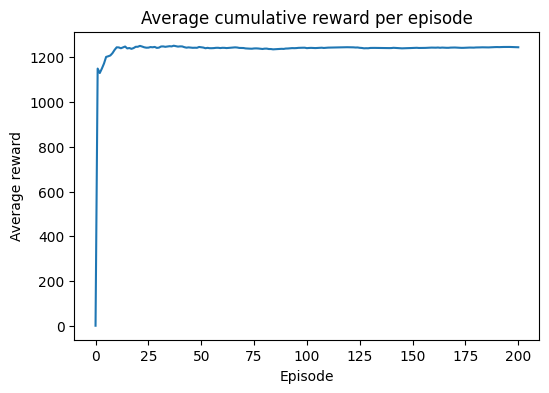

In [13]:
plt.figure(figsize=(6,4))
plt.plot(range(len(avg_rewards)), avg_rewards)
plt.title('Average cumulative reward per episode')
plt.xlabel('Episode')
plt.ylabel('Average reward')
None

The plot shows that the average reward is stabilizing. We call this the *value* associated with the policy that chooses actions randomly. In the next notebook, we will discuss policies and how to compute their values.

# Exercises

## Exercise 1

An interesting question is whether the average cumulative reward per episode depends on the initial condition. To investigate if this is the case, let's estimate the average reward for each different initial state.

Create a Tiny Robot environment with the same configuration as above, but with a deterministic initial state. For example, to start the environment always in state $0$, use the initial distribution $[1, 0, 0, 0]$. Then, simulate the MDP for $1000$ episodes, with length $50$ for each episode. Print the final average cumulative reward.

Repeat the simulation for each of the other three possible initial states. Determine if the average cumulative rewards depend on the initial state.

## Exercise 2

Simulate the process assuming that the robot alternates between actions $0$ and $1$. Run a simulation for $1000$ episodes of length $50$ and compare the average cumulative reward per episode with the randomized policy we simulated above. Run a separate simulation for each initial state.

## Exercise 3

Now suppose the robot chooses action $0$ when in states $0$ and $2$, and action $1$ when in states $1$ and $3$. Run a simulation as in the previous exercises to estimate the average cumulative reward per episode for all possible initial states.

## Exercise 4

Can you find a choice of actions that performs better than the choices in exercises 1 to 3? How could you sistematically search for the best possible way to choose the actions?

## Exercise 5

How can we be sure that the number of episodes simulated is large enough to give a good estimate for the average cumulative reward? One way to access this is to compute a *confidence interval*. Follow the outline below to do this for the policy that chooses the actions and initial states randomly:

- Modify the code so that, instead of storing the average reward, it records the cumulative rewards for each episode in a Numpy array `cumulative_rewards`.

- Compute the average $\mu$ and standard deviation $\sigma$ of the array of cumulative rewards. This can be done with the functions `np.mean()` and `np.std_dev()`

- The 95% confidence interval is given by the formula:
$$
\left(\mu-1.96\frac{\sigma}{\sqrt{N_\text{episodes}}}, \mu+1.96\frac{\sigma}{\sqrt{N_\text{episodes}}}\right),
$$

## Exercise 6

Repeat the previous exercise for the case where the initial state is chosen deterministically (you will have to run 4 simulations). Does this provide evidence for the hypothesis that the average reward per episode is different for each initial state?

## Exercise 5

Consider a network server that handles service requests. Requests are queued in order of arrival. Time is discretized, and in each time step a new request arrives with probability $p$.

The server can allocate different levels of service to handle a request (for example, the server may decide dedicate a larger number of CPU cores to a task). If $r$ resources are allocated to handle a request, the probability that it is finished by the next time step is:
$$
q(r)=\tanh(\alpha r),
$$
where $r$ is a non-negative integer with $r\lt r_{\text{max}}$, and $0\lt\alpha\lt1$. $\tanh$ is the hyperbolic tangent function, that can be computed with the function `np.tanh()`

There are two costs associated with processing the requests:

- In each time step, if there are $n$ requests in the system (either waiting for service or being currently processed), a cost of $\beta n^2$ is incurred, where $\alpha$ is a positive real number.

- If $r$ resources are allocated, a cost $\gamma r$ is incurred, where $\beta$ is a positive real number.

The server can hold at most $K$ requests. If a request arrives when the system is full, the request is ignored and a cost $c$ is incurred. Initially, there are no requests in the server.

Notice that, in this MDP, we want to minimize costs, instead of maximizing rewards. This can be modeled by *negative* rewards.

Use the `MDPEnvironment` class to define the environment for this MDP problem with the following parameters:

- $p=0.6$

- $K=30$ and $c=100$

- $\alpha=0.7$

- $\beta=0.1$

- $\gamma=0.3$

Then use the environment you defined to simulate the MDP.

Suppose resources are allocated as follows, where Let $N_R$ be the number of requests currently in the system.

- $N_R=0$: $r=0$

- $1\le N_R\lt 10$: $r=1$

- $11\le N_R\lt 20$: $r=2$

- $21\le N_R\lt 30$: $r=3$

Assume episodes of length $100$, and we want to estimate the average cumulative cost per episode. At the beginning of each episode there are no requests in the server.

Simulate several episodes, and estimate the average cost per episode. The number of episodes to be simulated should be large enough so that you can be confident that you have a reasonable estimate for the average cost per episode. Some experimentation may be necessary. If you are feeling ambitious, you can compute a confidence interval for the average cost.

*Hint*: The transition probability matrix is too large to be entered manually. Create an array of zeros, and compute the transition probabilities programatically. The same hint applies to the rewards array.


## Exercise 6

A state $s$ is called a *terminal state* if, for any action chosen, the transition probability from $s$ to $s$ is $1$ (and, consequently, transitions to other states have probability $0$).

Modify the class `MTPEnvironment` to support terminal states. Your class should be able to handle the following situations:

- Upon reaching terminal state, the MDP simulation should stop. This is indicated by setting `self._status` to 2.

- Trying to call `step()` for a terminated run raises an exception.

- When a terminal state is reached, a *terminal reward* is awarded. The terminal reward can depend on the state, but not on the action.

- An episode consists of running the MDP until a terminal state is reached.

Notice that it is possible that a terminal state is never reached. In this case, when simulating the MDP, it is still necessary to set an upper bound for the number of steps.

## Exercise 7

Use the class defined in Exercise 6 to define version of Tiny Robot modified as follows:

- The robot has an energy store that initially holds 15 units of energy.

- The robot spends one unit of energy to move to the next room.

- In each time step, the robot gains $0$, $1$ or $2$ units of energy, according to the following distribution:

<center>

| Energy gained | Probability |
|:-------------:|:-----------:|
|0              |0.5          |
|1              |0.3          |
|2              |0.2          |

</center>

When the robot runs out of energy, the episode ends.

Simulate this MDP assuming that the initial state is random and estimate the average reward per episode.

